In [ ]:
import requests
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
import ijson # Import the ijson library for streaming

# Suppress specific warnings for cleaner output if needed
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Configuration ---
DATA_URL = "https://huggingface.co/datasets/Raswanth/I24_MOTION/resolve/main/637b023440527bf2daa5932f__post1.json"
LOCAL_JSON_FILENAME = "637b023440527bf2daa5932f__post1.json"
LANE_WIDTH_FT = 12.0 # Standard lane width assumption

# --- Download Data if necessary ---
if not os.path.exists(LOCAL_JSON_FILENAME):
    print(f"Downloading data from {DATA_URL}...")
    try:
        response = requests.get(DATA_URL, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes
        with open(LOCAL_JSON_FILENAME, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Data saved to {LOCAL_JSON_FILENAME}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading data: {e}")
        exit()
else:
    print(f"Using local data file: {LOCAL_JSON_FILENAME}")

# --- Load Data using ijson for streaming ---
data = []
print("Loading data using streaming parser (ijson)...")
try:
    with open(LOCAL_JSON_FILENAME, 'r', encoding='utf-8') as f: # Specify encoding
        # Assuming the JSON is a list of objects at the root level
        # 'item' tells ijson to yield each element of the root list
        parser = ijson.items(f, 'item')
        for record in parser:
            data.append(record)
    print(f"Loaded {len(data)} vehicle records from JSON.")
except ijson.JSONError as e:
    print(f"Error parsing JSON with ijson: {e}")
    exit()
except FileNotFoundError:
    print(f"Error: Local JSON file not found at {LOCAL_JSON_FILENAME}")
    exit()
except Exception as e: # Catch other potential errors like memory issues during list append
    print(f"An unexpected error occurred during loading: {e}")
    exit()


# --- Initial Data Exploration (Optional but Recommended) ---
if data:
    print("\nSample vehicle record fields:")
    print(list(data[0].keys()))
    # print("\nSample vehicle data:")
    # print(data[0]) # Uncomment to see full first record
else:
    print("No data loaded. Exiting.")
    exit()

# --- Define Lane Boundaries ---
# Explore y_position range to define lanes appropriately
all_y_positions = []
for vehicle in data:
    if isinstance(vehicle, dict) and "y_position" in vehicle and isinstance(vehicle["y_position"], list): # Check if y_position is a list
        # Ensure y_positions are numbers before extending
        numeric_y = [y for y in vehicle["y_position"] if isinstance(y, (int, float))]
        all_y_positions.extend(numeric_y)


if not all_y_positions:
    print("No valid y_position data found.")
    exit()

min_y_overall = min(all_y_positions)
max_y_overall = max(all_y_positions)
print(f"\nOverall Y-Position Range: {min_y_overall:.2f} ft to {max_y_overall:.2f} ft")

# Define lanes based on 12ft intervals, starting near the minimum y
# Adjust the starting point if needed based on the actual road layout knowledge
lane_start_y = np.floor(min_y_overall / LANE_WIDTH_FT) * LANE_WIDTH_FT
num_lanes_total = int(np.ceil((max_y_overall - lane_start_y) / LANE_WIDTH_FT))
lane_boundaries = [lane_start_y + i * LANE_WIDTH_FT for i in range(num_lanes_total + 1)]

print(f"Defined {num_lanes_total} lanes based on Y-range and {LANE_WIDTH_FT}ft width.")
print(f"Lane Boundaries: {[f'{b:.1f}' for b in lane_boundaries]}")

def assign_lane(y_pos, boundaries):
    """Assigns a lane number based on y-position."""
    if not isinstance(y_pos, (int, float)): # Check if y_pos is numeric
        return None
    for i in range(len(boundaries) - 1):
        if boundaries[i] <= y_pos < boundaries[i+1]:
            return i + 1 # Lanes numbered starting from 1
    # Handle edge case where y_pos might be exactly the max boundary
    if y_pos == boundaries[-1]:
         return len(boundaries) - 1
    return None # Outside defined lanes

# --- Process Data into DataFrame ---
processed_data = []
vehicles_skipped_short = 0
vehicles_skipped_lane = 0
vehicles_skipped_dir = 0
vehicles_skipped_data_type = 0

for vehicle in data:
    # Basic structure and type checks
    if not isinstance(vehicle, dict) or \
       not all(k in vehicle for k in ["x_position", "timestamp", "y_position", "_id", "direction"]) or \
       not isinstance(vehicle["x_position"], list) or \
       not isinstance(vehicle["timestamp"], list) or \
       not isinstance(vehicle["y_position"], list) or \
       not isinstance(vehicle["_id"], dict) or \
       "$oid" not in vehicle["_id"]:
        vehicles_skipped_data_type += 1
        continue

    vehicle_id = vehicle["_id"]["$oid"]
    # Convert to numpy arrays and filter out non-numeric data if necessary
    try:
        timestamps = np.array([t for t in vehicle["timestamp"] if isinstance(t, (int, float))])
        x_positions = np.array([x for x in vehicle["x_position"] if isinstance(x, (int, float))])
        y_positions = np.array([y for y in vehicle["y_position"] if isinstance(y, (int, float))])
    except ValueError: # Handle potential issues during array conversion
        vehicles_skipped_data_type += 1
        continue
        
    direction = vehicle["direction"]

    if direction not in [1, -1]:
        vehicles_skipped_dir += 1
        continue # Skip undefined directions

    if len(timestamps) < 2 or len(x_positions) < 2 or len(y_positions) == 0:
        vehicles_skipped_short += 1
        continue # Need at least two points for speed, and some y_pos for lane

    # Ensure arrays have compatible lengths after filtering
    min_len = min(len(timestamps), len(x_positions), len(y_positions))
    if min_len < 2: # Check again after filtering
         vehicles_skipped_short += 1
         continue
         
    timestamps = timestamps[:min_len]
    x_positions = x_positions[:min_len]
    y_positions = y_positions[:min_len]


    # Assign vehicle to a lane based on its average y-position
    avg_y = np.mean(y_positions)
    assigned_lane = assign_lane(avg_y, lane_boundaries)

    if assigned_lane is None:
        vehicles_skipped_lane +=1
        continue # Skip vehicles outside defined lanes

    # Calculate instantaneous speeds
    dx = np.diff(x_positions)
    dt = np.diff(timestamps)

    # Avoid division by zero or near-zero dt
    valid_indices = dt > 1e-6
    speeds = np.full_like(dt, np.nan) # Initialize with NaN
    speeds[valid_indices] = dx[valid_indices] / dt[valid_indices]

    # Keep track of data points: speed corresponds to the interval *between* t[i] and t[i+1]
    # We'll associate the speed with the *start* of the interval (t[i], y[i])
    for i in range(len(speeds)):
        if not np.isnan(speeds[i]): # Only add valid speeds
             processed_data.append({
                "vehicle_id": vehicle_id,
                "timestamp": timestamps[i],
                "relative_time": timestamps[i] - min_timestamp, # Normalize time
                "x_position": x_positions[i],
                "y_position": y_positions[i],
                "speed_fps": speeds[i],
                "speed_mph": speeds[i] * 3600 / 5280, # Convert ft/s to mph
                "direction": "EB" if direction == 1 else "WB",
                "lane": assigned_lane
            })

df = pd.DataFrame(processed_data)

print(f"\nSkipped {vehicles_skipped_data_type} vehicles due to missing or invalid data types.")
print(f"Skipped {vehicles_skipped_short} vehicles with < 2 valid data points.")
print(f"Skipped {vehicles_skipped_lane} vehicles falling outside defined lanes.")
print(f"Skipped {vehicles_skipped_dir} vehicles with invalid direction.")

if df.empty:
    print("\nNo valid data points were processed into the DataFrame. Exiting.")
    exit()

print(f"Created DataFrame with {len(df)} speed data points.")
print("\nDataFrame Info:")
df.info()
print("\nSample DataFrame rows:")
print(df.head())
print("\nDescriptive statistics for speed (mph):")
print(df['speed_mph'].describe())

# --- Filter out unrealistic speeds (optional but recommended) ---
# Example: Filter speeds outside 0-100 mph range
original_count = len(df)
df = df[(df['speed_mph'] >= 0) & (df['speed_mph'] <= 100)]
filtered_count = len(df)
print(f"\nFiltered out {original_count - filtered_count} unrealistic speed data points (kept speeds between 0 and 100 mph).")
print(f"DataFrame now has {filtered_count} data points.")

if df.empty:
    print("\nDataFrame is empty after filtering speeds. Exiting.")
    exit()


# --- Group by Direction and Lane ---
grouped_stats = df.groupby(['direction', 'lane'])['speed_mph'].agg(['mean', 'median', 'std', 'count']).reset_index()

print("\nAverage Speed Statistics per Lane (MPH):")
print(grouped_stats)

# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style

# Box Plot for Speed Distribution by Lane
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Check if there's data for Eastbound before plotting
df_eb = df[df['direction'] == 'EB']
if not df_eb.empty:
    sns.boxplot(ax=axes[0], data=df_eb, x='lane', y='speed_mph', palette='viridis', order=sorted(df_eb['lane'].unique()))
    axes[0].set_title('Eastbound Speed Distribution by Lane')
    axes[0].set_xlabel('Lane Number')
    axes[0].set_ylabel('Speed (MPH)')
else:
    axes[0].set_title('No Eastbound Data')
    axes[0].set_xlabel('Lane Number')
    axes[0].set_ylabel('Speed (MPH)')


# Check if there's data for Westbound before plotting
df_wb = df[df['direction'] == 'WB']
if not df_wb.empty:
    sns.boxplot(ax=axes[1], data=df_wb, x='lane', y='speed_mph', palette='viridis', order=sorted(df_wb['lane'].unique()))
    axes[1].set_title('Westbound Speed Distribution by Lane')
    axes[1].set_xlabel('Lane Number')
    axes[1].set_ylabel('') # Remove redundant y-label
else:
     axes[1].set_title('No Westbound Data')
     axes[1].set_xlabel('Lane Number')
     axes[1].set_ylabel('')

plt.suptitle('Speed Distribution by Lane and Direction', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# Histograms/KDE Plots for Speed Distribution by Lane
if not df_eb.empty:
    num_eb_lanes = df_eb['lane'].nunique()
    g_eb = sns.FacetGrid(df_eb, col="lane", col_wrap=min(num_eb_lanes, 4), height=4, sharey=False, sharex=False, col_order=sorted(df_eb['lane'].unique()))
    g_eb.map(sns.histplot, "speed_mph", kde=True, bins=15)
    g_eb.fig.suptitle('Eastbound Speed Distributions per Lane', y=1.02, fontsize=14)
    g_eb.set_axis_labels("Speed (MPH)", "Count")
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping Eastbound histogram/KDE plots (no data).")


if not df_wb.empty:
    num_wb_lanes = df_wb['lane'].nunique()
    g_wb = sns.FacetGrid(df_wb, col="lane", col_wrap=min(num_wb_lanes, 4), height=4, sharey=False, sharex=False, col_order=sorted(df_wb['lane'].unique()))
    g_wb.map(sns.histplot, "speed_mph", kde=True, bins=15)
    g_wb.fig.suptitle('Westbound Speed Distributions per Lane', y=1.02, fontsize=14)
    g_wb.set_axis_labels("Speed (MPH)", "Count")
    plt.tight_layout()
    plt.show()
else:
     print("\nSkipping Westbound histogram/KDE plots (no data).")


# --- Statistical Tests ---

print("\n--- Statistical Analysis (ANOVA & Tukey's HSD) ---")

# Function to perform ANOVA and Tukey's HSD
def analyze_lanes(direction_df, direction_name):
    print(f"\nAnalyzing {direction_name} Lanes:")

    unique_lanes = sorted(direction_df['lane'].unique())
    if len(unique_lanes) < 2:
        print("  Not enough lanes for comparison.")
        return

    # Prepare data for ANOVA: list of speeds for each lane
    lane_groups = [direction_df[direction_df['lane'] == lane]['speed_mph']
                   for lane in unique_lanes]

    # Check if any lane group has insufficient data for ANOVA
    if any(len(group) < 2 for group in lane_groups):
        print("  Could not perform ANOVA (one or more lanes have less than 2 data points).")
        return

    # ANOVA
    try:
        f_stat, p_value_anova = stats.f_oneway(*lane_groups)
        print(f"  ANOVA Results:")
        print(f"    F-statistic: {f_stat:.4f}")
        print(f"    P-value: {p_value_anova:.4g}")

        if p_value_anova < 0.05:
            print("    Result: Significant difference found between at least one pair of lanes (p < 0.05).")

            # Tukey's HSD Post-hoc Test
            try:
                # Ensure the 'groups' argument uses the actual lane numbers/labels
                tukey_result = pairwise_tukeyhsd(endog=direction_df['speed_mph'],
                                                 groups=direction_df['lane'],
                                                 alpha=0.05)
                print("\n  Tukey's HSD Post-hoc Test Results:")
                print(tukey_result)

                # Plot Tukey's HSD results
                fig = tukey_result.plot_simultaneous()
                plt.title(f"Tukey's HSD Comparison for {direction_name} Lanes")
                plt.show()

            except Exception as e_tukey:
                print(f"    Could not perform Tukey's HSD test: {e_tukey}")

        else:
            print("    Result: No significant difference found between lane mean speeds (p >= 0.05).")

    except ValueError as e_anova:
         print(f"    Could not perform ANOVA (likely due to data issues like NaNs or variance): {e_anova}")
    except Exception as e_general:
         print(f"    An error occurred during ANOVA: {e_general}")


# Analyze Eastbound lanes
if not df_eb.empty:
    analyze_lanes(df_eb, "Eastbound")
else:
    print("\nNo Eastbound data to analyze statistically.")

# Analyze Westbound lanes
if not df_wb.empty:
    analyze_lanes(df_wb, "Westbound")
else:
    print("\nNo Westbound data to analyze statistically.")

print("\n--- Analysis Complete ---")

Using local data file: 637b023440527bf2daa5932f__post1.json
Loading data using streaming parser (ijson)...


In [ ]:
# --- Define Lane Boundaries ---
# Explore y_position range to define lanes appropriately
all_y_positions = []
for vehicle in data:
    if isinstance(vehicle, dict) and "y_position" in vehicle:
        all_y_positions.extend(vehicle["y_position"])

if not all_y_positions:
    print("No y_position data found.")
    exit()

min_y_overall = min(all_y_positions)
max_y_overall = max(all_y_positions)
print(f"\nOverall Y-Position Range: {min_y_overall:.2f} ft to {max_y_overall:.2f} ft")

# Define lanes based on 12ft intervals, starting near the minimum y
# Adjust the starting point if needed based on the actual road layout knowledge
lane_start_y = np.floor(min_y_overall / LANE_WIDTH_FT) * LANE_WIDTH_FT 
num_lanes_total = int(np.ceil((max_y_overall - lane_start_y) / LANE_WIDTH_FT))
lane_boundaries = [lane_start_y + i * LANE_WIDTH_FT for i in range(num_lanes_total + 1)]

print(f"Defined {num_lanes_total} lanes based on Y-range and {LANE_WIDTH_FT}ft width.")
print(f"Lane Boundaries: {[f'{b:.1f}' for b in lane_boundaries]}")

def assign_lane(y_pos, boundaries):
    """Assigns a lane number based on y-position."""
    for i in range(len(boundaries) - 1):
        if boundaries[i] <= y_pos < boundaries[i+1]:
            return i + 1 # Lanes numbered starting from 1
    # Handle edge case where y_pos might be exactly the max boundary
    if y_pos == boundaries[-1]:
         return len(boundaries) - 1
    return None # Outside defined lanes

# --- Process Data into DataFrame ---
processed_data = []
vehicles_skipped_short = 0
vehicles_skipped_lane = 0
vehicles_skipped_dir = 0

for vehicle in data:
    if not isinstance(vehicle, dict) or "x_position" not in vehicle or "timestamp" not in vehicle or "y_position" not in vehicle or "_id" not in vehicle or "direction" not in vehicle:
        continue

    vehicle_id = vehicle["_id"]["$oid"]
    timestamps = np.array(vehicle["timestamp"])
    x_positions = np.array(vehicle["x_position"])
    y_positions = np.array(vehicle["y_position"])
    direction = vehicle["direction"]

    if direction not in [1, -1]:
        vehicles_skipped_dir += 1
        continue # Skip undefined directions

    if len(timestamps) < 2:
        vehicles_skipped_short += 1
        continue # Need at least two points to calculate speed

    # Assign vehicle to a lane based on its average y-position
    avg_y = np.mean(y_positions)
    assigned_lane = assign_lane(avg_y, lane_boundaries)

    if assigned_lane is None:
        vehicles_skipped_lane +=1
        continue # Skip vehicles outside defined lanes

    # Calculate instantaneous speeds
    dx = np.diff(x_positions)
    dt = np.diff(timestamps)
    
    # Avoid division by zero or near-zero dt
    valid_indices = dt > 1e-6 
    speeds = np.full_like(dt, np.nan) # Initialize with NaN
    speeds[valid_indices] = dx[valid_indices] / dt[valid_indices]
    
    # Keep track of data points: speed corresponds to the interval *between* t[i] and t[i+1]
    # We'll associate the speed with the *start* of the interval (t[i], y[i])
    for i in range(len(speeds)):
        if not np.isnan(speeds[i]): # Only add valid speeds
             processed_data.append({
                "vehicle_id": vehicle_id,
                "timestamp": timestamps[i],
                "relative_time": timestamps[i] - min_timestamp, # Normalize time
                "x_position": x_positions[i],
                "y_position": y_positions[i],
                "speed_fps": speeds[i],
                "speed_mph": speeds[i] * 3600 / 5280, # Convert ft/s to mph
                "direction": "EB" if direction == 1 else "WB",
                "lane": assigned_lane
            })

df = pd.DataFrame(processed_data)

print(f"\nSkipped {vehicles_skipped_short} vehicles with < 2 data points.")
print(f"Skipped {vehicles_skipped_lane} vehicles falling outside defined lanes.")
print(f"Skipped {vehicles_skipped_dir} vehicles with invalid direction.")
print(f"Created DataFrame with {len(df)} speed data points.")
print("\nDataFrame Info:")
df.info()
print("\nSample DataFrame rows:")
print(df.head())
print("\nDescriptive statistics for speed (mph):")
print(df['speed_mph'].describe())

# --- Filter out unrealistic speeds (optional but recommended) ---
# Example: Filter speeds outside 0-100 mph range
original_count = len(df)
df = df[(df['speed_mph'] >= 0) & (df['speed_mph'] <= 100)]
filtered_count = len(df)
print(f"\nFiltered out {original_count - filtered_count} unrealistic speed data points (kept speeds between 0 and 100 mph).")
print(f"DataFrame now has {filtered_count} data points.")

Loaded 313 vehicles from JSON

Fields in first vehicle: ['_id', 'configuration_id', 'local_fragment_id', 'compute_node_id', 'coarse_vehicle_class', 'fine_vehicle_class', 'timestamp', 'raw timestamp', 'first_timestamp', 'last_timestamp', 'road_segment_ids', 'x_position', 'y_position', 'starting_x', 'ending_x', 'camera_snapshots', 'flags', 'length', 'width', 'height', 'direction', 'x_score', 'y_score', 'conflicts', 'leaders', 'gaps', 'feasibility']


In [ ]:
# --- Group by Direction and Lane ---
grouped_stats = df.groupby(['direction', 'lane'])['speed_mph'].agg(['mean', 'median', 'std', 'count']).reset_index()

print("\nAverage Speed Statistics per Lane (MPH):")
print(grouped_stats)

# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style

# Box Plot for Speed Distribution by Lane
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.boxplot(ax=axes[0], data=df[df['direction'] == 'EB'], x='lane', y='speed_mph', palette='viridis')
axes[0].set_title('Eastbound Speed Distribution by Lane')
axes[0].set_xlabel('Lane Number')
axes[0].set_ylabel('Speed (MPH)')

sns.boxplot(ax=axes[1], data=df[df['direction'] == 'WB'], x='lane', y='speed_mph', palette='viridis')
axes[1].set_title('Westbound Speed Distribution by Lane')
axes[1].set_xlabel('Lane Number')
axes[1].set_ylabel('') # Remove redundant y-label

plt.suptitle('Speed Distribution by Lane and Direction', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# Histograms/KDE Plots for Speed Distribution by Lane
g_eb = sns.FacetGrid(df[df['direction'] == 'EB'], col="lane", col_wrap=min(num_lanes_total, 4), height=4, sharey=False, sharex=False)
g_eb.map(sns.histplot, "speed_mph", kde=True, bins=15)
g_eb.fig.suptitle('Eastbound Speed Distributions per Lane', y=1.02, fontsize=14)
g_eb.set_axis_labels("Speed (MPH)", "Count")
plt.tight_layout()
plt.show()

g_wb = sns.FacetGrid(df[df['direction'] == 'WB'], col="lane", col_wrap=min(num_lanes_total, 4), height=4, sharey=False, sharex=False)
g_wb.map(sns.histplot, "speed_mph", kde=True, bins=15)
g_wb.fig.suptitle('Westbound Speed Distributions per Lane', y=1.02, fontsize=14)
g_wb.set_axis_labels("Speed (MPH)", "Count")
plt.tight_layout()
plt.show()

Loaded 321 vehicles from JSON

Fields in first vehicle: ['_id', 'timestamp', 'x_position', 'y_position', 'flags', 'length', 'width', 'height', 'merged_ids', 'road_segment_ids', 'fragment_ids', 'coarse_vehicle_class', 'fine_vehicle_class', 'direction', 'compute_node_id', 'local_fragment_id', 'starting_x', 'first_timestamp', 'configuration_id', 'ending_x', 'last_timestamp', 'x_score', 'y_score', 'feasibility']


In [ ]:
# --- Statistical Tests ---

print("\n--- Statistical Analysis (ANOVA & Tukey's HSD) ---")

# Function to perform ANOVA and Tukey's HSD
def analyze_lanes(direction_df, direction_name):
    print(f"\nAnalyzing {direction_name} Lanes:")
    
    # Prepare data for ANOVA: list of speeds for each lane
    lane_groups = [direction_df[direction_df['lane'] == lane]['speed_mph'] 
                   for lane in sorted(direction_df['lane'].unique())]
    
    if len(lane_groups) < 2:
        print("  Not enough lanes for comparison.")
        return

    # ANOVA
    try:
        f_stat, p_value_anova = stats.f_oneway(*lane_groups)
        print(f"  ANOVA Results:")
        print(f"    F-statistic: {f_stat:.4f}")
        print(f"    P-value: {p_value_anova:.4g}")

        if p_value_anova < 0.05:
            print("    Result: Significant difference found between at least one pair of lanes (p < 0.05).")
            
            # Tukey's HSD Post-hoc Test
            try:
                tukey_result = pairwise_tukeyhsd(endog=direction_df['speed_mph'], 
                                                 groups=direction_df['lane'], 
                                                 alpha=0.05)
                print("\n  Tukey's HSD Post-hoc Test Results:")
                print(tukey_result)
                
                # Plot Tukey's HSD results
                fig = tukey_result.plot_simultaneous()
                plt.title(f"Tukey's HSD Comparison for {direction_name} Lanes")
                plt.show()

            except Exception as e_tukey:
                print(f"    Could not perform Tukey's HSD test: {e_tukey}")

        else:
            print("    Result: No significant difference found between lane mean speeds (p >= 0.05).")
            
    except ValueError as e_anova:
         print(f"    Could not perform ANOVA (likely insufficient data in one or more lanes): {e_anova}")
    except Exception as e_general:
         print(f"    An error occurred during ANOVA: {e_general}")


# Analyze Eastbound lanes
df_eb = df[df['direction'] == 'EB']
if not df_eb.empty:
    analyze_lanes(df_eb, "Eastbound")
else:
    print("\nNo Eastbound data to analyze.")

# Analyze Westbound lanes
df_wb = df[df['direction'] == 'WB']
if not df_wb.empty:
    analyze_lanes(df_wb, "Westbound")
else:
    print("\nNo Westbound data to analyze.")

print("\n--- Analysis Complete ---")

First vehicle data:
{'_id': {'$oid': '641b0196011a0ef5ce805ea7'}, 'configuration_id': -1, 'local_fragment_id': 2976, 'compute_node_id': 'DEFAULT', 'coarse_vehicle_class': 1, 'fine_vehicle_class': -1, 'timestamp': [1623877161.11, 1623877161.18, 1623877161.32, 1623877161.45, 1623877161.52, 1623877161.58, 1623877161.65, 1623877161.72, 1623877161.78, 1623877161.85, 1623877161.92, 1623877161.99, 1623877162.05, 1623877162.12, 1623877162.19, 1623877162.2514434, 1623877162.3214433, 1623877162.3914435, 1623877162.4514434, 1623877162.5214434, 1623877162.59, 1623877162.65, 1623877162.72, 1623877162.79, 1623877162.8485565, 1623877162.9185567, 1623877162.9885566, 1623877163.0585566, 1623877163.1185565, 1623877163.1871133, 1623877163.2571132, 1623877163.3171132, 1623877163.3871133, 1623877163.45567, 1623877163.5171132, 1623877163.5871131, 1623877163.6571133, 1623877163.7171133, 1623877163.7871132, 1623877163.8571131, 1623877163.9271133, 1623877163.9885566, 1623877164.0571132, 1623877164.12567, 16238

In [7]:
# Extract y_position values from all vehicles
y_positions = []
for vehicle in vehicles:
	y_positions.extend(vehicle["y_position"])

# Calculate min and max
min_y = min(y_positions)
max_y = max(y_positions)

# Calculate range (optional)
range_y = max_y - min_y

# Print results
print(f"Minimum y_position: {min_y} ft")
print(f"Maximum y_position: {max_y} ft")
print(f"Range of y_position: {range_y} ft")

Minimum y_position: 2.352339029312134 ft
Maximum y_position: 119.03050994873047 ft
Range of y_position: 116.67817091941833 ft


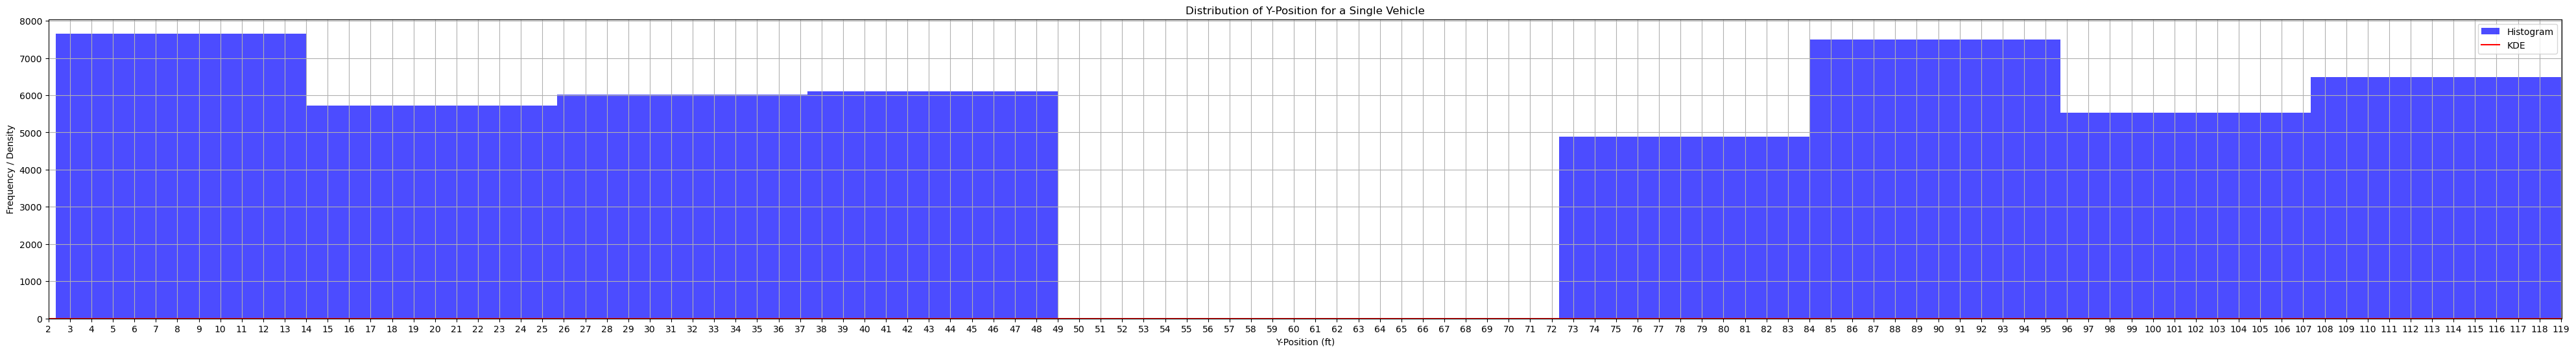

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(50, 6))

# Histogram
plt.hist(y_positions, bins=10, alpha=0.7, color='blue', label='Histogram')

# KDE (optional, requires seaborn)
sns.kdeplot(y_positions, color='red', label='KDE')

# Add labels and title
plt.xlabel("Y-Position (ft)")
plt.ylabel("Frequency / Density")
plt.title("Distribution of Y-Position for a Single Vehicle")
plt.legend()
plt.grid(True)
plt.xlim(min_y, max_y)  # Set x-axis limits to the min and max y_position values
#need in 1 ft increments
plt.xticks([i * 1 for i in range(int(min_y), int(max_y) + 1)])
# Set y-axis limits (optional)
plt.ylim(0, plt.ylim()[1])  # Set y-axis limits to start from 0
# Show plot
plt.show()

C:\Users\Raswanth\AppData\Local\Temp\ipykernel_24268\3011721970.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')  # Using tab20 colormap which has 20 distinct colors


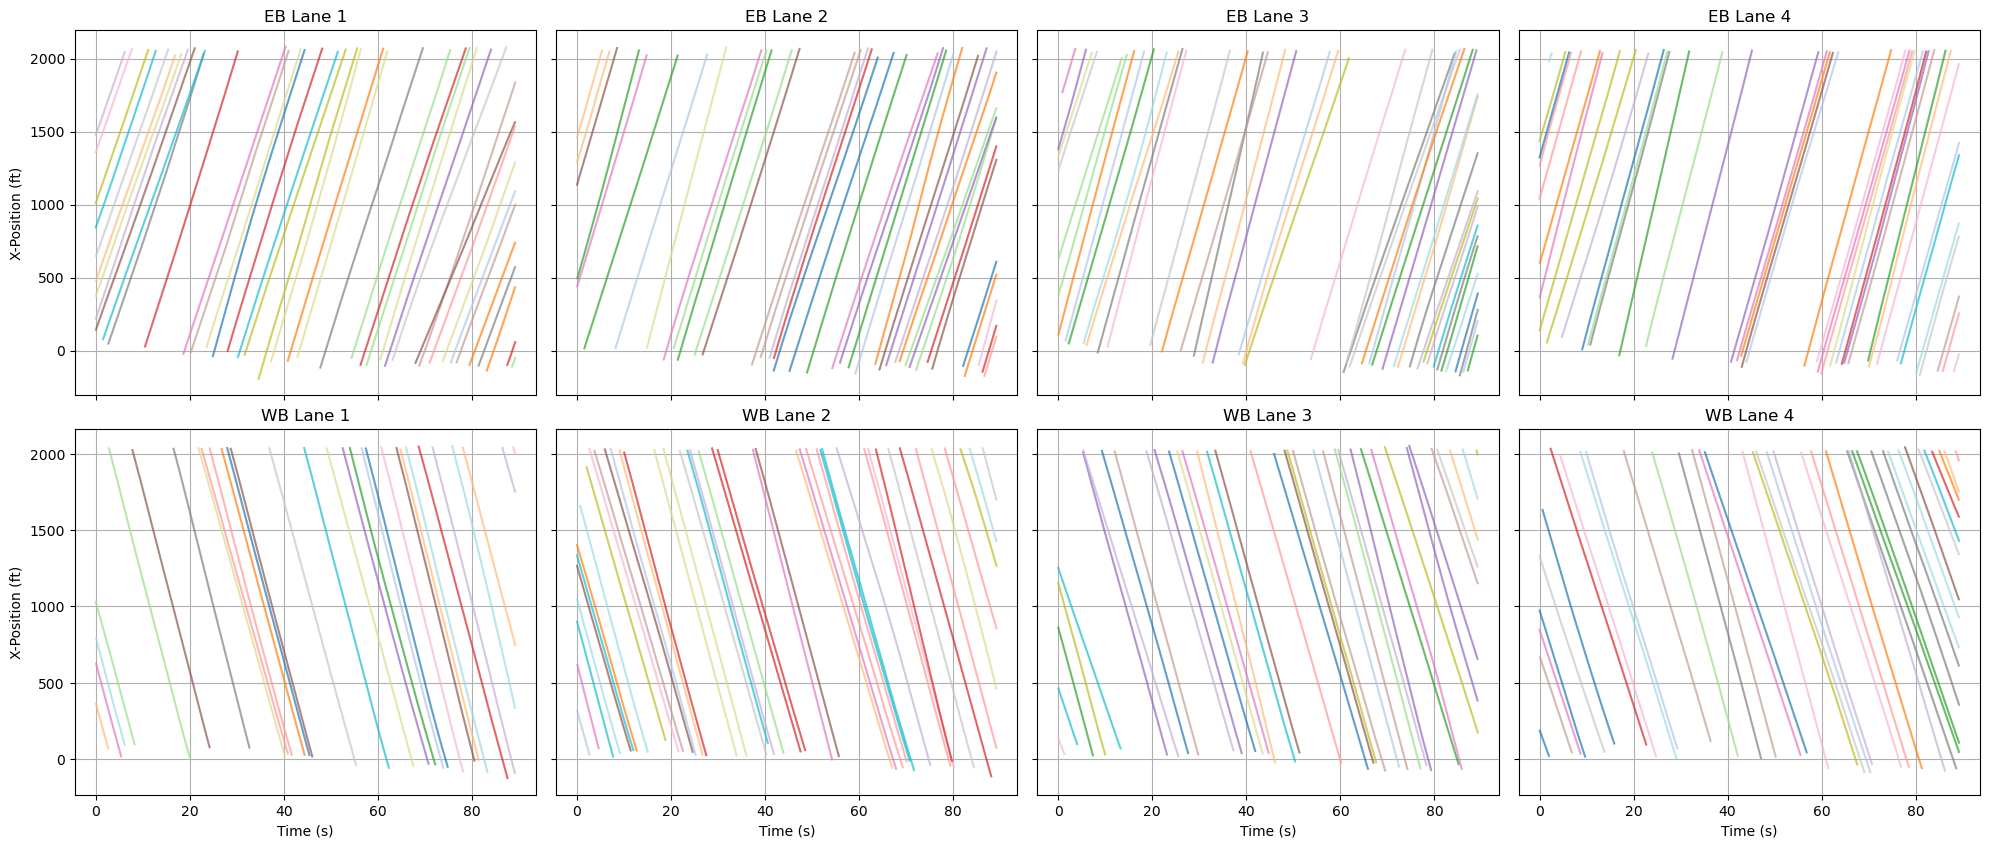

In [16]:
import matplotlib.pyplot as plt
import json
import glob
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap

# Load all JSON files
json_files = glob.glob("GT_i.json") 

# Collect y_positions and timestamps by direction
eb_y_positions = []
wb_y_positions = []
all_timestamps = []

for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
        # Check if data is a list or a dictionary
        if isinstance(data, list):
            # Process each vehicle in the list
            for vehicle in data:
                if isinstance(vehicle, dict) and "direction" in vehicle:
                    direction = vehicle["direction"]
                    if direction in [1, -1]:
                        y_positions = vehicle["y_position"]
                        all_timestamps.extend(vehicle["timestamp"])
                        if direction == 1:
                            eb_y_positions.extend(y_positions)
                        elif direction == -1:
                            wb_y_positions.extend(y_positions)

# Find min and max y_positions for each direction
min_y_eb = min(eb_y_positions) if eb_y_positions else 0
max_y_eb = max(eb_y_positions) if eb_y_positions else 12
min_y_wb = min(wb_y_positions) if wb_y_positions else -12
max_y_wb = max(wb_y_positions) if wb_y_positions else 0

# Calculate number of lanes (round up to ensure all data is included)
num_lanes_eb = int(np.ceil((max_y_eb - min_y_eb) / 12))
num_lanes_wb = int(np.ceil((max_y_wb - min_y_wb) / 12))
max_lanes = max(num_lanes_eb, num_lanes_wb)

# Define lane boundaries
eb_lane_bounds = [min_y_eb + i * 12 for i in range(num_lanes_eb + 1)]
wb_lane_bounds = [max_y_wb - i * 12 for i in range(num_lanes_wb + 1)][::-1]  # Reverse for descending order

# Find min timestamp for normalization
min_timestamp = min(all_timestamps) if all_timestamps else 0

# Get a colormap for vehicle IDs
cmap = get_cmap('tab20')  # Using tab20 colormap which has 20 distinct colors
all_vehicle_ids = set()  # To collect all unique vehicle IDs

# First pass to collect all vehicle IDs
for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
        if isinstance(data, list):
            for vehicle in data:
                if isinstance(vehicle, dict) and "_id" in vehicle:
                    # Extract the string ID from the _id dictionary
                    all_vehicle_ids.add(vehicle["_id"]["$oid"])

# Create a mapping of vehicle IDs to colors
id_to_color = {}
for i, vehicle_id in enumerate(all_vehicle_ids):
    # Use modulo to cycle through colormap if there are more vehicles than colors
    id_to_color[vehicle_id] = cmap(i % 20)

# Initialize trajectories dictionary with ID information
trajectories = {
    "EB": {f"Lane {i+1}": [] for i in range(max_lanes)},
    "WB": {f"Lane {i+1}": [] for i in range(max_lanes)}
}

# Function to assign lane based on y_avg
def get_lane(y_avg, direction):
    if direction == 1:  # Eastbound
        for i in range(len(eb_lane_bounds) - 1):
            if eb_lane_bounds[i] <= y_avg < eb_lane_bounds[i + 1]:
                return i + 1
    elif direction == -1:  # Westbound
        for i in range(len(wb_lane_bounds) - 1):
            if wb_lane_bounds[i] <= y_avg < wb_lane_bounds[i + 1]:
                return i + 1
    return None

# Process each vehicle
for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
        # Check if data is a list or a dictionary
        if isinstance(data, list):
            # Process each vehicle in the list
            for vehicle in data:
                if not isinstance(vehicle, dict) or "direction" not in vehicle:
                    continue
                
                # Skip vehicle if it doesn't have an ID
                if "_id" not in vehicle:
                    continue
                
                direction = vehicle["direction"]
                if direction not in [1, -1]:
                    continue
                vehicle_id = vehicle["_id"]["$oid"]  # Use the string ID value
                y_positions = vehicle["y_position"]
                y_avg = np.mean(y_positions)
                lane = get_lane(y_avg, direction)
                
                if lane is None or lane > max_lanes:
                    continue
                
                normalized_timestamps = [t - min_timestamp for t in vehicle["timestamp"]]
                x_positions = vehicle["x_position"]
                # Store trajectory with color information
                trajectory = (normalized_timestamps, x_positions, id_to_color[vehicle_id], vehicle_id)
                lane_key = f"Lane {lane}"
                
                if direction == 1:
                    trajectories["EB"][lane_key].append(trajectory)
                elif direction == -1:
                    trajectories["WB"][lane_key].append(trajectory)

# Create subplots
fig, axs = plt.subplots(2, max_lanes, figsize=(5 * max_lanes, 10), sharex='all', sharey='row')

# Handle case where max_lanes = 1 (axs becomes 1D)
if max_lanes == 1:
    axs = np.array([axs]).T  # Convert to 2D array for consistent indexing

# Plot EB lanes
for i in range(max_lanes):
    axs[0, i].set_title(f"EB Lane {i + 1}")
    for trajectory in trajectories["EB"][f"Lane {i + 1}"]:
        timestamps, x_positions, color, vehicle_id = trajectory
        axs[0, i].plot(timestamps, x_positions, color=color, alpha=0.7, label=f"ID: {vehicle_id}")
    axs[0, i].grid(True)

# Plot WB lanes
for i in range(max_lanes):
    axs[1, i].set_title(f"WB Lane {i + 1}")
    for trajectory in trajectories["WB"][f"Lane {i + 1}"]:
        timestamps, x_positions, color, vehicle_id = trajectory
        axs[1, i].plot(timestamps, x_positions, color=color, alpha=0.7, label=f"ID: {vehicle_id}")
    axs[1, i].grid(True)

# Set labels
for ax in axs[1, :]:
    ax.set_xlabel("Time (s)")
for ax in axs[:, 0]:
    ax.set_ylabel("X-Position (ft)")


plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust for legend at bottom
plt.show()